# Tutorial: fitting a BL Lac broad-band SED using angpy and Gammapy

In order to perform a fit of the broad-band SED of a jetted AGN, `agnpy` includes a `Gammapy` wrapper.
A [Gammapy's `SpectralModel`](https://docs.gammapy.org/0.20/api/gammapy.modeling.models.SpectralModel.html) representing the emission due to one or more radiative processes can be defined. The `SpectralModel` can then be used either to fit flux points or to perform a forward-folding likelihood fit (if the instrument response is available in a format compatible with `Gammapy`). 

Several combination of radiative processes can be used to model the broad-band emission of a jetted AGN. For simplicity, we provide wrappers for the two scenarios most-commonly considered:
* `SycnhrotronSelfComptonSpectralModel`, representing the sum of synchrotron and synchrotron self-Compton radiation. This scenario is commonly considered to model BL Lac sources;
* `ExternalComptonSpectralModel`, representing the sum of synchrotron and synchrotron self-Compton radiation along with an external Compton component that can be computed over a list of targets. This scenario is commonly considered to model flat spectrum radio quasars.

In this tutorial we will show how to use the `SynchrotronSelfComptonSpectralModel` to fit the broad-band SED of Mrk 421, measured by a MWL campaign in 2009 [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract).

[gammapy](https://gammapy.org/) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import pkg_resources
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.constants import c
from astropy.table import Table
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.wrappers import SynchrotronSelfComptonSpectralModel
from agnpy.wrappers import add_systematic_errors_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label

# import gammapy classes
from gammapy.modeling.models import SPECTRAL_MODEL_REGISTRY, SkyModel
from gammapy.estimators import FluxPoints
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit

# IMPORTANT: add the new custom model to the registry of spectral models recognised by gammapy
SPECTRAL_MODEL_REGISTRY.append(SynchrotronSelfComptonSpectralModel)

### `gammapy` wrapper of agnpy synchrotron and SSC
The `SynchrotronSelfComptonSpectralModel` wraps the `agnpy` functions to compute synchrotron and SSC radiation and returns a `Gammapy` `SpectralModel`. To initialise this spectral model, only the electron distribution has to be specified, the remaining parameters (the ones of the blob) will be initialised automatically and can be modified at a later stage.

In [2]:
# electron energy distribution
n_e = BrokenPowerLaw(
    k_e=1e-8 * u.Unit("cm-3"),
    p1=2.02,
    p2=3.43,
    gamma_b=1e5,
    gamma_min=500,
    gamma_max=1e6,
)

# initialise the Gammapy SpectralModel
ssc_model = SynchrotronSelfComptonSpectralModel(n_e)

We can display all the parameters of the model at once

In [3]:
ssc_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str1,int64,float64,float64,bool,bool,str1
spectral,log10_k_e,-8.0000e+00,,0.000e+00,-1.000e+01,1.000e+01,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,5.0000e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,2.6990e+00,,0.000e+00,1.000e+00,3.000e+00,True,False,
spectral,log10_gamma_max,6.0000e+00,,0.000e+00,5.000e+00,8.000e+00,True,False,
spectral,z,1.0000e-01,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.0000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-2.0000e+00,,0.000e+00,-4.000e+00,2.000e+00,False,False,


or display separately the parameters related to the electrons energy distribution

In [4]:
ssc_model.spectral_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str1,int64,float64,float64,bool,bool,str1
spectral,log10_k_e,-8.0000e+00,,0.000e+00,-1.000e+01,1.000e+01,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,5.0000e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,2.6990e+00,,0.000e+00,1.000e+00,3.000e+00,True,False,
spectral,log10_gamma_max,6.0000e+00,,0.000e+00,5.000e+00,8.000e+00,True,False,


and the parameters related to the emission region, the blob in this case

In [5]:
ssc_model.emission_region_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str7,float64,str1,int64,float64,float64,bool,bool,str1
spectral,z,1.0000e-01,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.0000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-2.0000e+00,,0.000e+00,-4.000e+00,2.000e+00,False,False,
spectral,t_var,6.0000e+02,s,0.000e+00,1.000e+01,3.142e+07,False,False,


Let us set some reasonable initial parameters. For example, let us set the proper redshift for Mrk421 and values for the other parameters that will give our fit a decent starting point.

In [6]:
# reasonable intial parameters
ssc_model.parameters["z"].value = 0.0308
ssc_model.parameters["delta_D"].value = 18
ssc_model.parameters["t_var"].value = (1 * u.d).to_value("s")
ssc_model.parameters["t_var"].frozen = True
ssc_model.parameters["log10_B"].value = -1.3

Let us check that they were correctly updated

In [7]:
ssc_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str1,int64,float64,float64,bool,bool,str1
spectral,log10_k_e,-8.0000e+00,,0.000e+00,-1.000e+01,1.000e+01,False,False,
spectral,p1,2.0200e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.4300e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,5.0000e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,2.6990e+00,,0.000e+00,1.000e+00,3.000e+00,True,False,
spectral,log10_gamma_max,6.0000e+00,,0.000e+00,5.000e+00,8.000e+00,True,False,
spectral,z,3.0800e-02,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.8000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-1.3000e+00,,0.000e+00,-4.000e+00,2.000e+00,False,False,


### Fit with `gammapy`
Here we start the procedure to fit with `Gammapy`.

#### 1) load the MWL flux points 
The MWL SEDs included in the default `agnpy` data are automatically readable by `Gammapy`'s `FluxPoints`. We group the flux points by instrument, assigning each of them to a `FluxPointDataset` that we will then use for fitting.

It is important, if you are using your own MWL SED, to provide proper *provenace*, that is to specify the instrument to which instrument the measured flux points belong. This can be very helpful, as we show in this example, to set systematic errors on the different data sets.

In [8]:
datasets = Datasets()
flux_points = {}

sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")
table = Table.read(sed_path)
table = table.group_by("instrument")

# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())

for group in table.groups:
    name = group["instrument"][0]

    data = FluxPoints.from_table(group, sed_type="e2dnde", format="gadf-sed")
    dataset = FluxPointsDataset(data=data, name=name)

    flux_points.update({name: data})
    dataset.mask_fit = dataset.data.energy_ref > E_min_fit
    datasets.append(dataset)

# load the SSC model in the datasets
model = SkyModel(spectral_model=ssc_model, name="Mrk421")
datasets.models = [model]

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point 

#### 2) add systematic errors
Currently there is no function in `gammapy` handling systematic errors on flux points.
Let us manually add different systematic errors for different instruments, using the `add_systematic_errors_flux_points` function implemented in `agnpy.wrappers.gammapy`.

We express the systematic errors as a fraction of the measured flux (e.g $30\%$). We use a very rough and conservative estimate of the systematic errors ($30\%$ of the flux for VHE points, $10\%$ for HE and X-ray points, $5\%$ on all the other instruments data).   

We assume them to be independent from the statistical ones and sum the two in quadrature.   

In [9]:
# add systematic errors
for key in flux_points.keys():
    if key == "MAGIC":
        add_systematic_errors_flux_points(flux_points[key], 0.30)
    elif key in ["Fermi", "RXTE/PCA", "Swift/BAT", "Swift/XRT"]:
        add_systematic_errors_flux_points(flux_points[key], 0.10)
    else:
        add_systematic_errors_flux_points(flux_points[key], 0.05)

Let us plot all the flux points and the initial model 

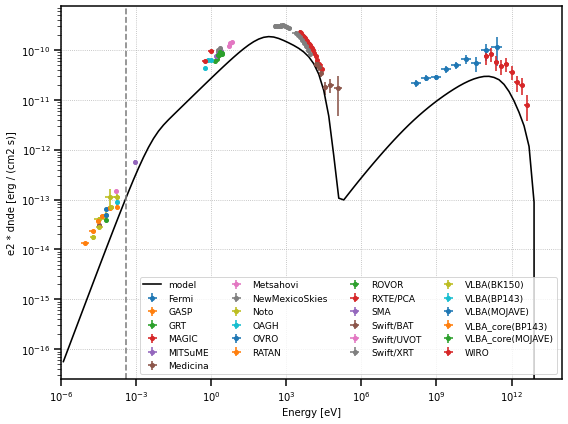

In [10]:
load_mpl_rc()
fig, ax = plt.subplots(figsize=(8, 6))

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

ssc_model.plot(
    energy_bounds=[1e-6, 1e14] * u.eV, energy_power=2, label="model", color="k", lw=1.6
)

# plot a line marking the minimum energy considered in the fit
ax.axvline(E_min_fit, ls="--", color="gray")

plt.legend(ncol=4, fontsize=9)
plt.xlim([1e-6, 1e14])
plt.show()

#### 3) run the fit

In [11]:
%%time
# define the fitter
fitter = Fit()
results = fitter.run(datasets)

CPU times: user 4min 32s, sys: 32.6 s, total: 5min 4s
Wall time: 5min 11s


In [12]:
print(results)
print(model.spectral_model.parameters.to_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 342
	total stat : 270.78

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

  type         name         value    unit   error      min        max    frozen is_norm link
-------- --------------- ----------- ---- --------- ---------- --------- ------ ------- ----
spectral       log10_k_e -7.8836e+00      7.206e-02 -1.000e+01 1.000e+01  False   False     
spectral              p1  2.0541e+00      2.509e-02  1.000e+00 5.000e+00  False   False     
spectral              p2  3.5406e+00      6.162e-02  1.000e+00 5.000e+00  False   False     
spectral   log10_gamma_b  4.9905e+00      2.431e-02  2.000e+00 6.000e+00  False   False     
spectral log10_gamma_min  2.6990e+00      0.000e+00  1.000e+00 3.000e+00   True   False     
spectral log10_gamma_max  6.0000e+00      0.000e+00  5.0

Now let us plot the final model and the flux points

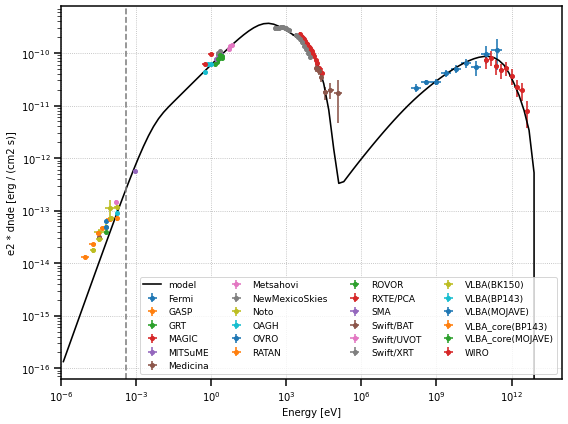

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

model.spectral_model.plot(
    energy_bounds=[1e-6, 1e14] * u.eV, energy_power=2, label="model", color="k", lw=1.6
)

# plot a line marking the minimum energy considered in the fit
ax.axvline(E_min_fit, ls="--", color="gray")

plt.legend(ncol=4, fontsize=9)
plt.xlim([1e-6, 1e14])
plt.show()

If you want to find more about fitting with Gammapy, you can checout [this tutorial](https://docs.gammapy.org/0.20.1/tutorials/api/fitting.html). To show the additional capabilities of the fitting with `Gammapy`, we illustrate how to visualise the migration matrix and asses the quality of the fit by plotting the likelihood profile of one of the parameters. 

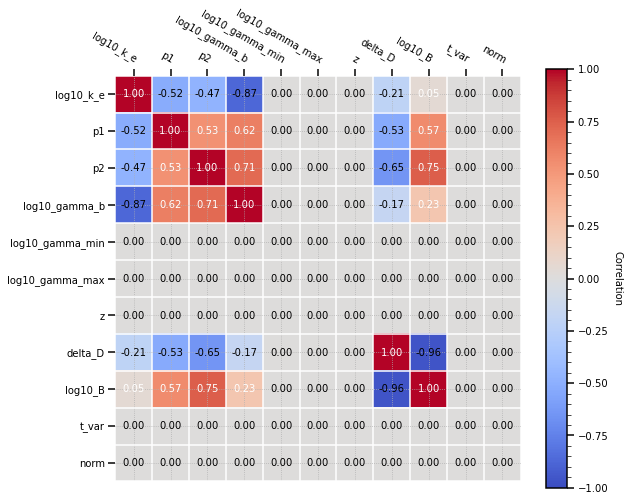

In [14]:
# plot the covariance matrix
model.spectral_model.covariance.plot_correlation()
plt.show()

In [15]:
%%time
# plot the profile for the normalisation of the electron energy distribution 
par = model.spectral_model.log10_k_e
par.scan_n_values = 50
profile = fitter.stat_profile(datasets=datasets, parameter=par)

# to compute the delta TS
total_stat = results.total_stat

CPU times: user 34.3 s, sys: 4.01 s, total: 38.3 s
Wall time: 38.4 s


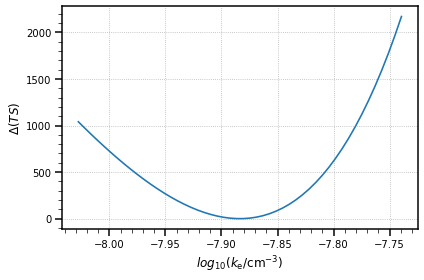

In [16]:
plt.plot(profile[f"{par.name}_scan"], profile["stat_scan"] - total_stat)
plt.ylabel(r"$\Delta(TS)$", size=12)
plt.xlabel(r"$log_{10}(k_{\rm e} / {\rm cm}^{-3})$", size=12)
plt.show()